In [2]:

from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import List


sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")


ll_o = Path("module/221215-123958-ll-o")
bu_o = Path("module/221215-124159-bu-o")
ll_c = Path("module/221215-124617-ll-c")
bu_c = Path("module/221215-124818-bu-c")

volatile_ll = Path("allocator/221218-141724")
peristent_ll = Path("allocator/221218-142957")

def read_orders(dir: str, orders: List[int]) -> pd.DataFrame:
    data = []
    for o in orders:
        d = pd.read_csv(f"{dir}/out_{o}.csv")
        d["order"] = str(o)
        data.append(d)
    data = pd.concat(data)
    data["cores"] = data["x"]
    data["get"] = data["get_avg"]
    data["put"] = data["put_avg"]
    return data


def read_allocs(ll: Path, bu: Path, bench: str, orders: List[int]) -> pd.DataFrame:
    ll_d = read_orders(ll / bench, orders)
    ll_d["alloc"] = "LLFree"
    bu_d = read_orders(bu / bench, orders)
    bu_d["alloc"] = "Buddy"
    return pd.concat([ll_d, bu_d])


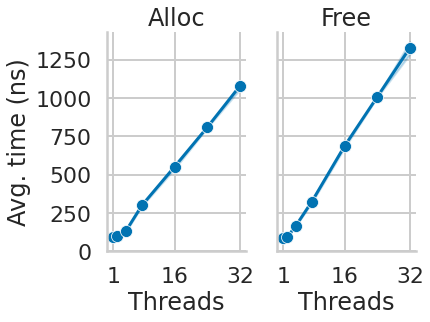

In [4]:
with sns.plotting_context("poster"):
    pgd = pd.read_csv(bu_c / "bulk" / "out_0.csv")
    pgd["alloc"] = "Buddy"
    pgd["cores"] = pgd["x"]
    pgd["Alloc"] = pgd["get_avg"]
    pgd["Free"] = pgd["put_avg"]
    pgd = pgd[["cores", "alloc", "Alloc", "Free"]].melt(
        id_vars=["cores", "alloc"],
        value_vars=["Alloc", "Free"], value_name="time")
    # pgd = pgd.groupby(["cores", "alloc", "variable", "mem"]).min()
    g = sns.relplot(data=pgd, kind="line", x="cores", y="time", legend=False,
                    col="variable", style="alloc", hue="alloc", markers=True,
                    aspect=0.64)
    g.set(xticks=[1, 16, 32])
    g.set(ylim=(0, None))
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Threads")
    g.set_titles("{col_name}")
    g.savefig("out/buddy_threads.pdf")


# Order Scaling

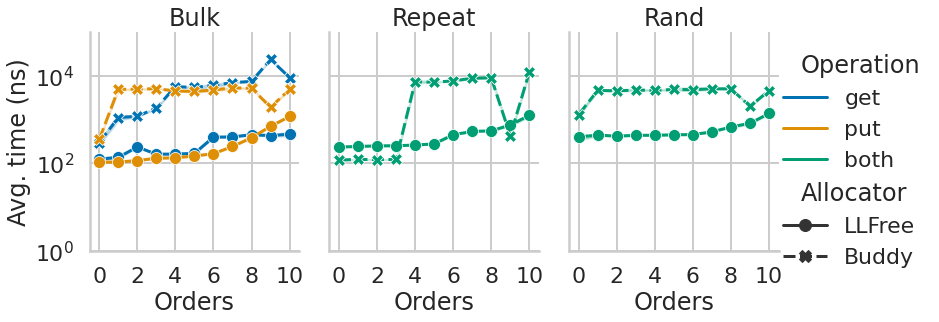

In [11]:

data_o_b = read_allocs(ll_o, bu_o, "bulk", list(range(11)))
data_o_b["bench"] = "Bulk"
data_o_r = read_allocs(ll_o, bu_o, "repeat", list(range(11)))
data_o_r["bench"] = "Repeat"
data_o_r["both"] = data_o_r["get"]
data_o_r["get"] = 0
data_o_r["put"] = 0
data_o_a = read_allocs(ll_o, bu_o, "rand", list(range(11)))
data_o_a["bench"] = "Rand"
data_o_a["both"] = data_o_a["get"]
data_o_a["get"] = 0
data_o_a["put"] = 0

data_o = pd.concat([data_o_b, data_o_r, data_o_a])
pgd = data_o[["bench", "order", "alloc", "iteration", "get", "put", "both"]].melt(
    id_vars=["bench", "order", "alloc", "iteration"],
    value_vars=["get", "put", "both"], value_name="time", var_name="Operation")
pgd["Allocator"] = pgd["alloc"]

with sns.plotting_context("poster"):
    g = sns.relplot(data=pgd, kind="line", x="order", y="time",
                    markers=True, col="bench",
                    hue="Operation", style="Allocator",
                    aspect=0.8, height=5)
    g.set(ylim=(1, 10**5))
    g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Orders")
    g.set(xticks=[0, 2, 4, 6, 8, 10])
    g.set_titles("{col_name}")
    g.savefig("out/module_o.pdf")


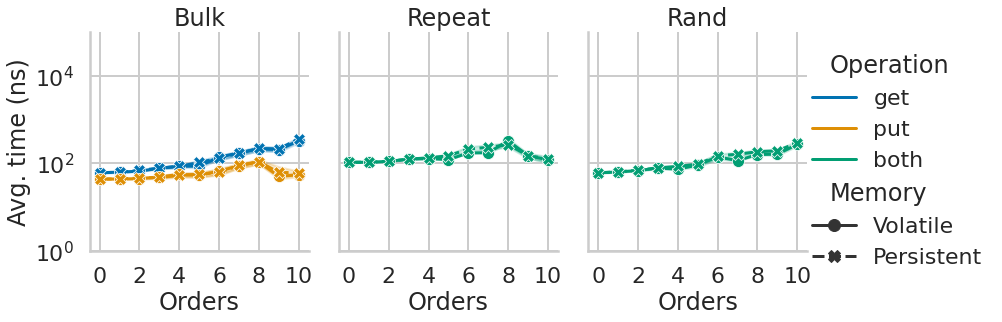

In [13]:
data_b = read_orders(volatile_ll / "bulk", list(range(11)))
data_b["bench"] = "Bulk"
data_b["Memory"] = "Volatile"
data_r = read_orders(volatile_ll / "repeat", list(range(11)))
data_r["bench"] = "Repeat"
data_r["both"] = data_r["get"]
data_r["get"] = 0
data_r["put"] = 0
data_r["Memory"] = "Volatile"
data_a = read_orders(volatile_ll / "rand", list(range(11)))
data_a["bench"] = "Rand"
data_a["both"] = data_a["get"]
data_a["get"] = 0
data_a["put"] = 0
data_a["Memory"] = "Volatile"

data_p_b = read_orders(peristent_ll / "bulk", list(range(11)))
data_p_b["bench"] = "Bulk"
data_p_b["Memory"] = "Persistent"
data_p_r = read_orders(peristent_ll / "repeat", list(range(11)))
data_p_r["bench"] = "Repeat"
data_p_r["both"] = data_p_r["get"]
data_p_r["get"] = 0
data_p_r["put"] = 0
data_p_r["Memory"] = "Persistent"
data_p_a = read_orders(peristent_ll / "rand", list(range(11)))
data_p_a["bench"] = "Rand"
data_p_a["both"] = data_p_a["get"]
data_p_a["get"] = 0
data_p_a["put"] = 0
data_p_a["Memory"] = "Persistent"

data = pd.concat([data_b, data_r, data_a, data_p_b, data_p_r, data_p_a])
pgd = data[["bench", "order", "cores", "Memory", "get", "put", "both"]].melt(
    id_vars=["bench", "order", "cores", "Memory"],
    value_vars=["get", "put", "both"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.relplot(data=pgd, kind="line", x="order", y="time", col="bench",
                    markers=True, hue="Operation", style="Memory",
                    aspect=0.8, height=5)
    g.set(ylim=(1, 10**5))
    g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Orders")
    g.set(xticks=[0, 2, 4, 6, 8, 10])
    g.set_titles("{col_name}")
    g.savefig("out/module_local.pdf")


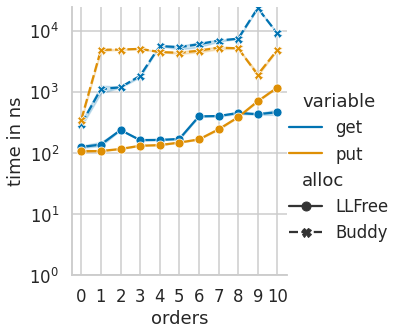

In [42]:
data_o = read_allocs(ll_o, bu_o, "bulk", list(range(11)))

pgd = data_o[["order", "alloc", "iteration", "get", "put"]].melt(
    id_vars=["order", "alloc", "iteration"],
    value_vars=["get", "put"], value_name="time")

order = ["LLFree", "Buddy"]
g = sns.relplot(data=pgd, kind="line", x="order", y="time",
                markers=True,
                hue="variable", style="alloc", style_order=order)
# g.set(xticks=[1, 16, 32, 48])
g.set(ylim=(1, None))
g.set(yscale="log")
# g.legend.set_title("Order")
g.set(ylabel="time in ns")
g.set(xlabel="orders")
g.set_titles("{col_name}")


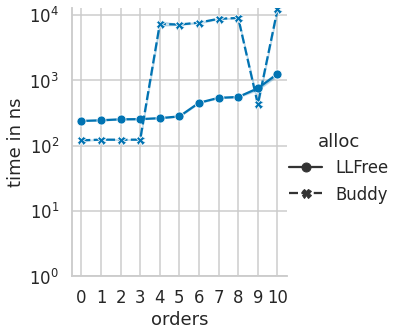

In [40]:
data_o = read_allocs(ll_o, bu_o, "repeat", list(range(11)))

pgd = data_o[["order", "alloc", "iteration", "get"]]

order = ["LLFree", "Buddy"]
g = sns.relplot(data=pgd, kind="line", x="order", y="get",
                markers=True,
                style="alloc", style_order=order)
# g.set(xticks=[1, 16, 32, 48])
g.set(ylim=(1, None))
g.set(yscale="log")
# g.legend.set_title("Order")
g.set(ylabel="time in ns")
g.set(xlabel="orders")
g.set_titles("{col_name}")


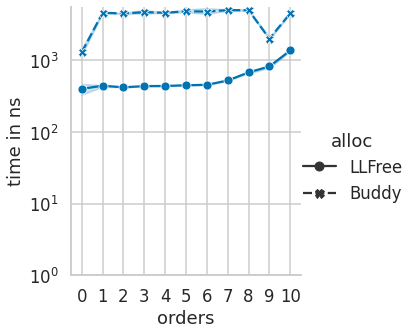

In [39]:
data_o = read_allocs(ll_o, bu_o, "rand", list(range(11)))

pgd = data_o[["order", "alloc", "iteration", "get"]]
order = ["LLFree", "Buddy"]
g = sns.relplot(data=pgd, kind="line", x="order", y="get",
                markers=True, style="alloc", style_order=order)
# g.set(xticks=[1, 16, 32, 48])
g.set(ylim=(1, None))
g.set(yscale="log")
# g.legend.set_title("Order")
g.set(ylabel="time in ns")
g.set(xlabel="orders")
g.set_titles("{col_name}")


# Multicore Scaling

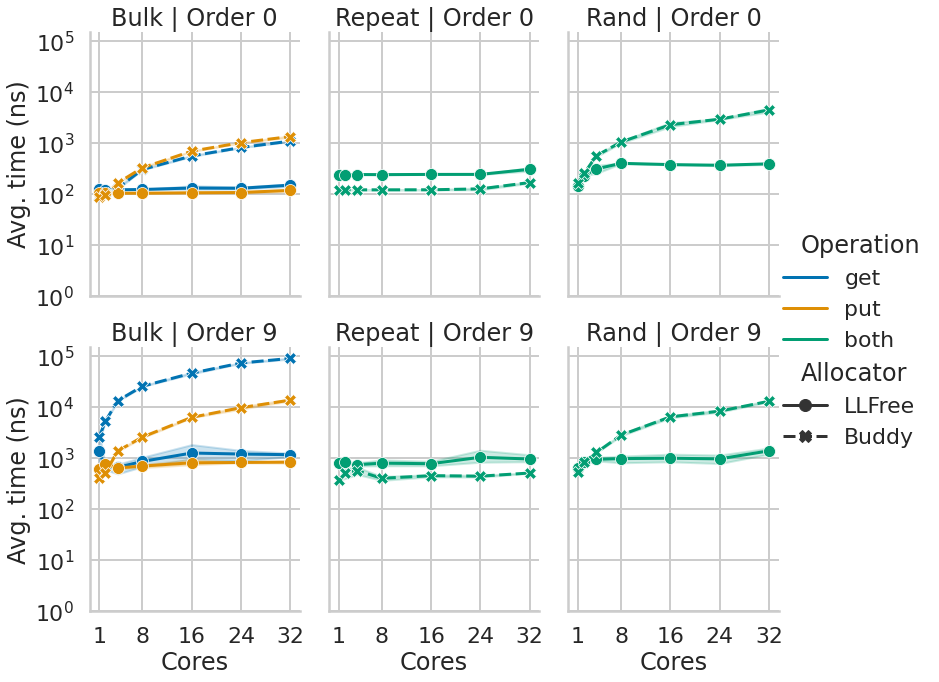

In [20]:

data_c_b = read_allocs(ll_c, bu_c, "bulk", [0, 9])
data_c_b["bench"] = "Bulk"
data_c_r = read_allocs(ll_c, bu_c, "repeat", [0, 9])
data_c_r["bench"] = "Repeat"
data_c_r["both"] = data_c_r["get"]
data_c_r["get"] = 0
data_c_r["put"] = 0
data_c_a = read_allocs(ll_c, bu_c, "rand", [0, 9])
data_c_a["bench"] = "Rand"
data_c_a["both"] = data_c_a["get"]
data_c_a["get"] = 0
data_c_a["put"] = 0

data_c = pd.concat([data_c_b, data_c_r, data_c_a])

pgd = data_c[["bench", "order", "cores", "alloc", "get", "put", "both"]].melt(
    id_vars=["bench", "order", "cores", "alloc"],
    value_vars=["get", "put", "both"], value_name="time", var_name="Operation")
pgd["Allocator"] = pgd["alloc"]

with sns.plotting_context("poster"):
    g = sns.relplot(data=pgd, kind="line", x="cores", y="time",
                    markers=True, row="order", col="bench",
                    style="Allocator", hue="Operation",
                    aspect=0.8, height=5)
    g.set(xticks=[1, 8, 16, 24, 32])
    g.set(ylim=(1, 10**5 * 1.5))
    g.set(yscale="log")
    # g.legend.set_title("Order")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles("{col_name} | Order {row_name}")
    g.savefig("out/module_c.pdf")


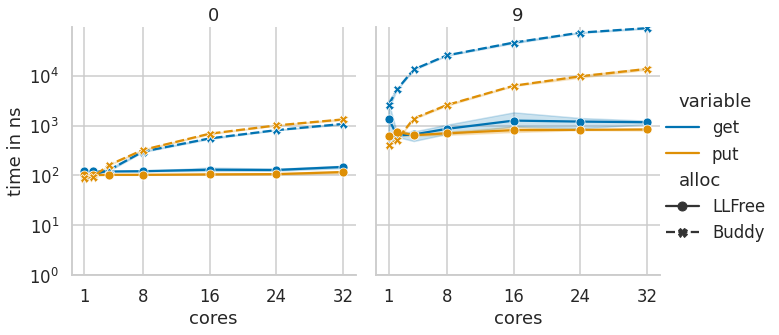

In [38]:
data_c = read_allocs(ll_c, bu_c, "bulk", [0, 9])

pgd = data_c[["order", "cores", "alloc", "get", "put"]].melt(
    id_vars=["order", "cores", "alloc"],
    value_vars=["get", "put"], value_name="time")
g = sns.relplot(data=pgd, kind="line", x="cores", y="time",
                markers=True, col="order",
                style="alloc", hue="variable")
g.set(xticks=[1, 8, 16, 24, 32])
g.set(ylim=(1, None))
g.set(yscale="log")
# g.legend.set_title("Order")
g.set(ylabel="time in ns")
g.set(xlabel="cores")
g.set_titles("{col_name}")


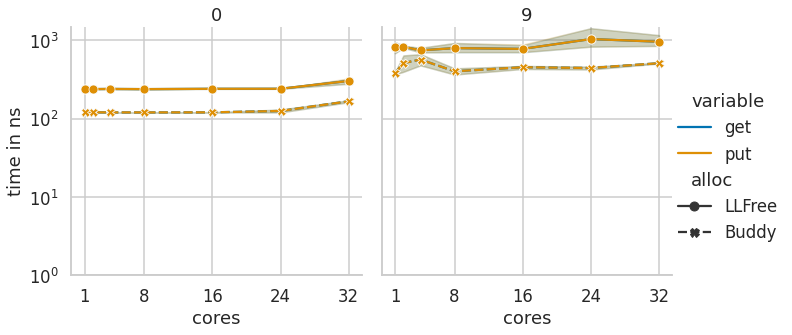

In [36]:
data_c = read_allocs(ll_c, bu_c, "repeat", [0, 9])

pgd = data_c[["order", "cores", "alloc", "get", "put"]].melt(
    id_vars=["order", "cores", "alloc"],
    value_vars=["get", "put"], value_name="time")
g = sns.relplot(data=pgd, kind="line", x="cores", y="time",
                markers=True, col="order",
                style="alloc", hue="variable")
g.set(xticks=[1, 8, 16, 24, 32])
g.set(ylim=(1, None))
g.set(yscale="log")
# g.legend.set_title("Order")
g.set(ylabel="time in ns")
g.set(xlabel="cores")
g.set_titles("{col_name}")


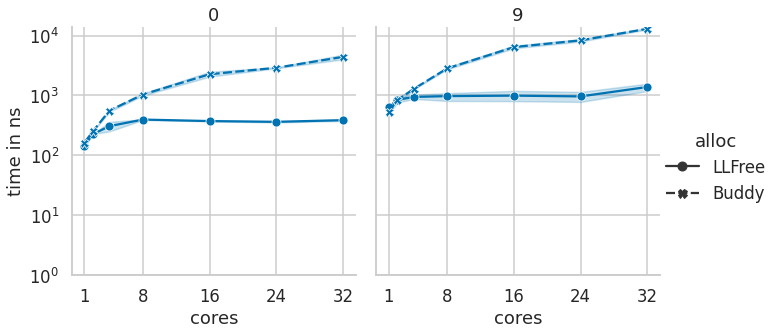

In [37]:
data_c = read_allocs(ll_c, bu_c, "rand", [0, 9])

g = sns.relplot(data=data_c, kind="line", x="cores", y="get",
                markers=True, col="order",
                style="alloc")
g.set(xticks=[1, 8, 16, 24, 32])
g.set(ylim=(1, None))
g.set(yscale="log")
# g.legend.set_title("Order")
g.set(ylabel="time in ns")
g.set(xlabel="cores")
g.set_titles("{col_name}")
